<a href="https://colab.research.google.com/github/lblogan14/master_tensorflow_keras/blob/master/ch10_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Code Prerequisite

In [1]:
import os

import numpy as np
np.random.seed(123)
print("NumPy:{}".format(np.__version__))

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=15,10
print("Matplotlib:{}".format(mpl.__version__))

import tensorflow as tf
tf.set_random_seed(123)
print("TensorFlow:{}".format(tf.__version__))

import keras
print("Keras:{}".format(keras.__version__))

NumPy:1.14.6
Matplotlib:2.1.2
TensorFlow:1.12.0
Keras:2.2.4


Using TensorFlow backend.


Autoencoder is a neural network architecture that is often associated with unsupervised
learning, dimensionality reduction, and data compression. Autoencoders learn to produce
the same output as given to the input layer by using lesser number of neurons in the hidden
layers. This allows hidden layers to learn the features of input with lesser number of
parameters. This process of using lesser number of neurons to learn the features of the input
data, in turn, reduces the dimensionality of the input dataset.

An autoencoder architecture has two stages: encoder and decoder. In the encoder stage, the
model learns to represent the input to a compressed vector with lesser dimensions, and in
the decoder stage, the model learns to represent the compressed vector to an output vector.

The loss is calculated as entropy distance between the output and input, thus by
minimizing the loss, we learn parameters that encode the input into a representation that is
capable of producing the input back, with yet another set of learned parameters.

#Autoencoder types
* **Simple autoencoder**: the hidden layers have lesser number of nodes or neurons as compared to the input. Simple autoencoders are also known as *undercomplete autoencoders*
 * Single-layer autoencoder generally does not perform well
 * Multi-layer autoencoder has more than one hidden layer, divided into encoder and decoder groupings.
Encoder layers encode a large number of features into a smaller number of
neurons, and decoder layers then decode the learned compressed features back
into the original or a reduced number of features. Multi-layer autoencoder is
known as the **stacked autoencoder**.

* **Sparse autoencoder**: a regularization term is added as the
penalty and hence, the representation becomes more sparse as compared to
simple autoencoders.
* **Denoising autoencoder** (DAE): the input is introduced with stochastic noise. The DAE recreates the input and attempts to remove noise. The loss function in the DAE compares the denoised recreated output to the original uncorrupted input.
* **Convolutional autoencoder** (CAE): use convolutional layers to create an autoencoder. For example, a simple CAE can have a structure like, \\
*input -> convolution -> pooling -> convolution -> pooling -> output* \\
The first set of convolution and pooling layers acts as the encoder, reducing the
high-dimensional input feature space to low dimensional feature space. The
second set of convolutional and pooling layers acts as the decoder, converting it
back to high-dimensional feature space.
* **Variational autoencoder** (VAE): VAE is a kind of generative
model, that is, it produces parameters of the probability distribution from which
the original data or the data very similar to original data can be generated. In a VAE, the encoder turns the input samples into parameters in latent space
using which the latent points are sampled. The decoder then uses the latent
points to regenerate the original input data. Hence, the focus of learning in VAE
shifts to maximizing the probability of the input data in place of trying to recreate
the output from input.

#MNIST data Preparation

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('mnist', one_hot=False)

x_train = mnist.train.images
x_test = mnist.test.images
y_train = mnist.train.labels
y_test = mnist.test.images

pixel_size = 28

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


Extract four distinct images and their respective labels from training and test datasets:

In [0]:
while True:
  train_images, train_labels = mnist.train.next_batch(4)
  if len(set(train_labels)) == 4:
    break
while True:
  test_images, test_labels = mnist.test.next_batch(4)
  if len(set(test_labels)) == 4:
    break

Create a help function to plot the extracted images

In [0]:
import random

# function to display the images and labels
# images should be in NHW or NHWC format
def display_images(images, labels, count=0, one_hot=False):
  # if number of images to display is not provided, then display all images
  if count==0:
    count = images.shape[0]
    
  idx_list = random.sample(range(len(labels)), count)
  for i in range(count):
    plt.subplot(4, 4, i+1)
    plt.title(labels[i])
    plt.imshow(images[i])
    plt.axis('off')
  plt.tight_layout
  plt.show()

#Stacked autoencoder in TensorFlow

In [0]:
# parameters
learning_rate = 0.001
n_epochs = 20
batch_size = 100
n_batches = int(mnist.train.num_examples/batch_size)

In [0]:
# number of pixels in the MNIST images as number of inputs
n_inputs = 28*28
n_outputs = n_inputs

In [0]:
tf.reset_default_graph()

In [0]:
# input images
x = tf.placeholder(dtype=tf.float32, name='x', shape=[None, n_inputs])
# output images
y = tf.placeholder(dtype=tf.float32, name='y', shape=[None, n_outputs])

Add the number of neurons for encoder and decoder layers as
`[512,256,256,512]`:

In [0]:
# number of hidden layers
n_layers = 2
# neurons in each hidden layer
n_neurons = [512, 256]
# add decoder layers
n_neurons.extend(list(reversed(n_neurons)))
n_layers = n_layers * 2

Define the `w` and `b` parameters:

In [0]:
w = []
b = []

for i in range(n_layers):
  w.append(tf.Variable(tf.random_normal([n_inputs if i==0 else n_neurons[i-1],
                                         n_neurons[i]]),
                      name='w_{0:04d}'.format(i)
                      )
          )
  b.append(tf.Variable(tf.zeros([n_neurons[i]]),
                      name='b_{0:04d}'.format(i)
                      )
          )
  
w.append(tf.Variable(tf.random_normal([n_neurons[n_layers-1] if n_layers > 0 else n_inputs,
                                       n_outputs]),
                    name='w_out'
                    )
        )
b.append(tf.Variable(tf.zeros([n_outputs]),
                    name='b_out'
                    )
        )

Build the network and use sigmoid activation function for each layer

In [0]:
# x is input layer
layer = x
# add hidden layer
for i in range(n_layers):
  layer = tf.nn.sigmoid(tf.matmul(layer, w[i]) + b[i])
# add output layer
layer = tf.nn.sigmoid(tf.matmul(layer, w[n_layers]) + b[n_layers])
model = layer

Define the `loss` funciton using `mean_square_error` and the `optimizer` function using `AdamOptimizer`

In [0]:
mse = tf.losses.mean_squared_error
loss = mse(predictions=model, labels=y)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer = optimizer.minimize(loss)

Train the model,

In [44]:
with tf.Session() as tfs:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for batch in range(n_batches):
            x_batch, _ = mnist.train.next_batch(batch_size)
            feed_dict={x: x_batch,y: x_batch}
            batch_loss, _ = tfs.run([loss, optimizer], feed_dict)
            epoch_loss += batch_loss 
        if (epoch%10==9) or (epoch==0):
            average_loss = epoch_loss / n_batches
            print('epoch: {0:04d}   loss = {1:0.6f}'
                  .format(epoch,
                          average_loss))

    # predict images using trained autoencoder model for later plotting           
    y_train_pred = tfs.run(model, feed_dict={x: train_images})
    y_test_pred = tfs.run(model, feed_dict={x: test_images})

epoch: 0000   loss = 0.144407
epoch: 0009   loss = 0.087657
epoch: 0019   loss = 0.074746


Display the  train images,

The first row indicates the actual images and second row indicates the generated images:

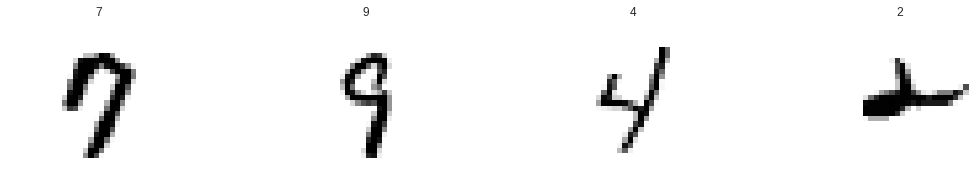

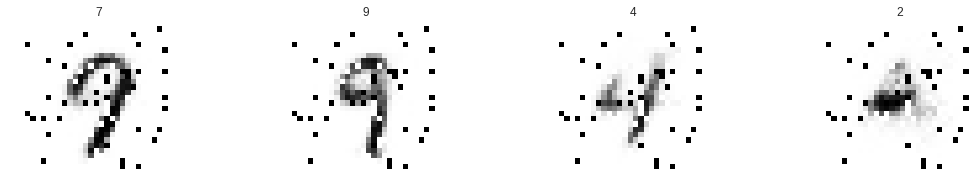

In [45]:
display_images(train_images.reshape(-1,pixel_size,pixel_size),train_labels)
display_images(y_train_pred.reshape(-1,pixel_size,pixel_size),train_labels)

The images generated have a little bit of noise that can be removed with more training and
hyper-parameter tuning.

The resul of predicting the test set images,

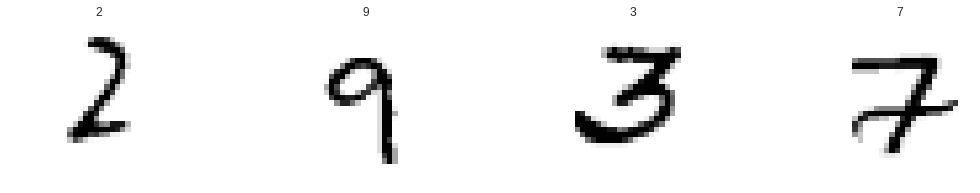

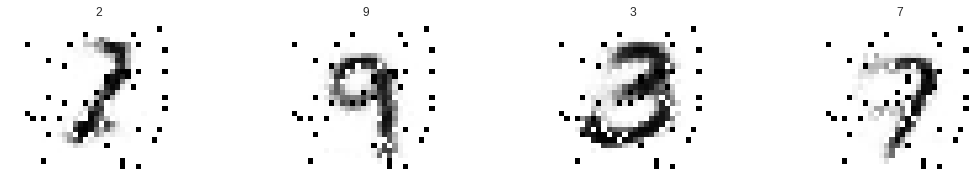

In [46]:
display_images(test_images.reshape(-1,pixel_size,pixel_size),test_labels)
display_images(y_test_pred.reshape(-1,pixel_size,pixel_size),test_labels)

#Stacked autoencoder in Keras

In [0]:
tf.reset_default_graph()
keras.backend.clear_session()

In [0]:
import keras
from keras.layers import Dense
from keras.models import Sequential

# parameters
learning_rate = 0.001
n_epochs = 20
batch_size = 100
n_batches = int(mnist.train.num_examples/batch_size)

# number of pixels in the MNIST image as number of inputs
n_inputs = 784
n_outputs = n_inputs

# number of hidden layers
n_layers = 2
# neurons in each hidden layer
n_neurons = [512,256]
# add decoder layers:
n_neurons.extend(list(reversed(n_neurons)))
n_layers = n_layers * 2

In [0]:
model = Sequential()
# add input to first layer
model.add(Dense(units=n_neurons[0], activation='relu',
                input_shape=(n_inputs,)))
# add rest of hidden layers
for i in range(1, n_layers):
  model.add(Dense(units=n_neurons[i], activation='relu'))
  
# add last layer as output layer
model.add(Dense(units=n_outputs, activation='linear'))

The difference here is to use `relu` activation for the hidden layers and `linear` activation for the final
layer:

In [50]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 784)               402192    
Total params: 1,132,816
Trainable params: 1,132,816
Non-trainable params: 0
_________________________________________________________________


In [52]:
model.compile(loss='mse',
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])
model.fit(x_train, x_train, batch_size=batch_size, epochs=n_epochs)

y_train_pred = model.predict(train_images)
y_test_pred = model.predict(test_images)

Epoch 1/20
55000/55000 [==============================] - 5s 86us/step - loss: 0.0197 - acc: 0.0129
Epoch 2/20
55000/55000 [==============================] - 5s 83us/step - loss: 0.0086 - acc: 0.0136
Epoch 3/20
55000/55000 [==============================] - 4s 81us/step - loss: 0.0070 - acc: 0.0142
Epoch 4/20
55000/55000 [==============================] - 4s 81us/step - loss: 0.0063 - acc: 0.0143
Epoch 5/20
55000/55000 [==============================] - 4s 82us/step - loss: 0.0058 - acc: 0.0148
Epoch 6/20
55000/55000 [==============================] - 4s 82us/step - loss: 0.0054 - acc: 0.0153
Epoch 7/20
55000/55000 [==============================] - 4s 81us/step - loss: 0.0052 - acc: 0.0158
Epoch 8/20
55000/55000 [==============================] - 4s 82us/step - loss: 0.0050 - acc: 0.0157
Epoch 9/20
55000/55000 [==============================] - 4s 81us/step - loss: 0.0048 - acc: 0.0166
Epoch 10/20
55000/55000 [==============================] - 4s 81us/step - loss: 0.0047 - acc: 0.0157

Display the train and test images generated by the model.

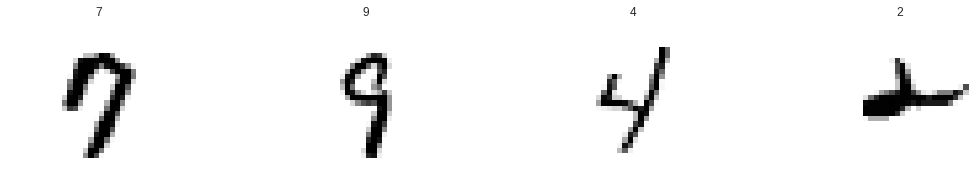

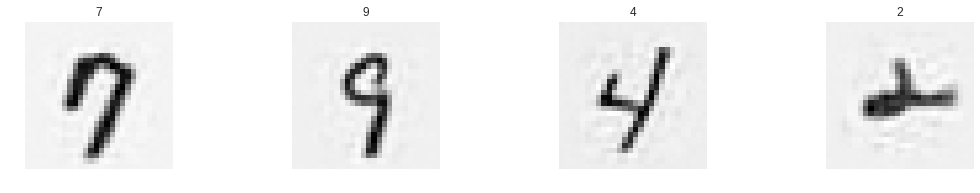

In [53]:
display_images(train_images.reshape(-1,pixel_size,pixel_size),train_labels)
display_images(y_train_pred.reshape(-1,pixel_size,pixel_size),train_labels)

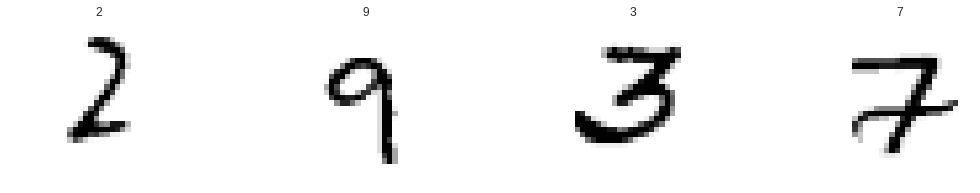

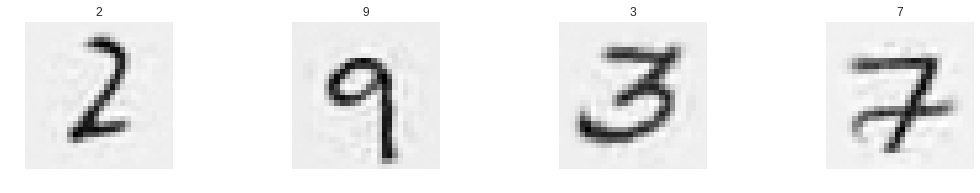

In [54]:
display_images(test_images.reshape(-1,pixel_size,pixel_size),test_labels)
display_images(y_test_pred.reshape(-1,pixel_size,pixel_size),test_labels)

#Denoising autoencoder in TensorFlow

Add noise to images

In [0]:
def add_noise(x):
  return x + 0.5 * np.random.randn(x.shape[0], x.shape[1])

In [0]:
test_images_noisy = add_noise(test_images)

Use these test images to test the output from our denoising model examples.

The training difference from stacked autoencoder is to use the noisy images as input for the input layer and check the reconstruction and denoising error with the non-noisy images while in the training session:

Thus, inside the `Session()`:

    x_batch, _ = mnist.train.next_batch(batch_size)
    x_batch_noisy = add_noise(x_batch)
    feed_dict = {x:x_batch_noisy, y:x_batch}
    batch_loss, _ = tfs.run([loss, optimizer], feed_dict=feed_dict)

In [0]:
tf.reset_default_graph()
keras.backend.clear_session()

In [0]:
# hyperparameters
learning_rate = 0.001
batch_size = 100
n_batches = int(mnist.train.num_examples/batch_size)

# number of pixels in the MNIST image as number of inputs
n_inputs = 784
n_outputs = n_inputs

# input images
x = tf.placeholder(dtype=tf.float32, name="x", shape=[None, n_inputs]) 

# output images
y = tf.placeholder(dtype=tf.float32, name="y", shape=[None, n_outputs]) 

# number of hidden layers
n_layers = 2
# neurons in each hidden layer
n_neurons = [512,256]

# add decoder layers:
n_neurons.extend(list(reversed(n_neurons)))
n_layers = n_layers * 2

In [0]:
w=[]
b=[]

for i in range(n_layers):
    # weights
    w.append(tf.Variable(tf.random_normal([n_inputs if i==0 else n_neurons[i-1],
                                           n_neurons[i]]),
                         name="w_{0:04d}".format(i) 
                        )
            ) 
    # biases
    b.append(tf.Variable(tf.zeros([n_neurons[i]]),
                         name="b_{0:04d}".format(i) 
                        )
            )                   
w.append(tf.Variable(tf.random_normal([n_neurons[n_layers-1] if n_layers > 0 else n_inputs,
                                       n_outputs]),
                     name="w_out"
                    )
        )
b.append(tf.Variable(tf.zeros([n_outputs]),name="b_out"))

In [0]:
# x is input layer
layer = x

# add hidden layers
for i in range(n_layers):
    layer = tf.nn.sigmoid(tf.matmul(layer, w[i]) + b[i]) 

# add output layer
layer = tf.nn.sigmoid(tf.matmul(layer, w[n_layers]) + b[n_layers])
    
model = layer

In [0]:
mse=tf.losses.mean_squared_error
loss = mse(predictions=model, labels=y)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer = optimizer.minimize(loss)

In [62]:
n_epochs = 100

with tf.Session() as tfs:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for batch in range(n_batches):
            x_batch, _ = mnist.train.next_batch(batch_size)
            x_batch_noisy = add_noise(x_batch)
            feed_dict={x: x_batch_noisy, y: x_batch}
            _,batch_loss = tfs.run([optimizer,loss], feed_dict=feed_dict)
            epoch_loss += batch_loss 
        if (epoch%10==9) or (epoch==0):
            average_loss = epoch_loss / n_batches
            print('epoch: {0:04d}   loss = {1:0.6f}'
                  .format(epoch,average_loss))
            
    y_test_pred1 = tfs.run(model, feed_dict={x: test_images})
    y_test_pred2 = tfs.run(model, feed_dict={x: test_images_noisy})

epoch: 0000   loss = 0.145800
epoch: 0009   loss = 0.096470
epoch: 0019   loss = 0.086858
epoch: 0029   loss = 0.082124
epoch: 0039   loss = 0.079159
epoch: 0049   loss = 0.077475
epoch: 0059   loss = 0.076212
epoch: 0069   loss = 0.074691
epoch: 0079   loss = 0.073923
epoch: 0089   loss = 0.071757
epoch: 0099   loss = 0.071126


Display the test images generated from the DAE model;

First row: the original non-noisy test images \\
Second row: the generated test
images:

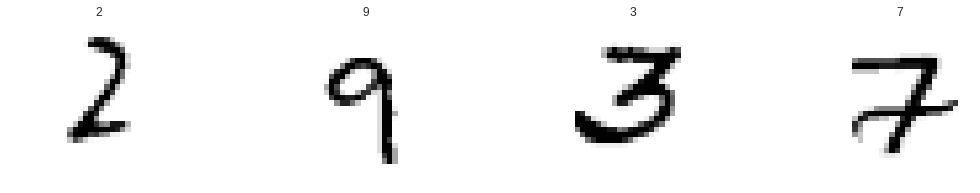

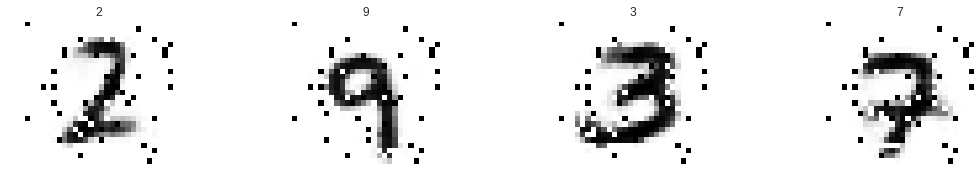

In [63]:
display_images(test_images.reshape(-1,pixel_size,pixel_size),test_labels)
display_images(y_test_pred1.reshape(-1,pixel_size,pixel_size),test_labels)

Display the generated images when we input the noisy test images:
First row: the orignal noisy test images \\
Second row: the generated denoised test images

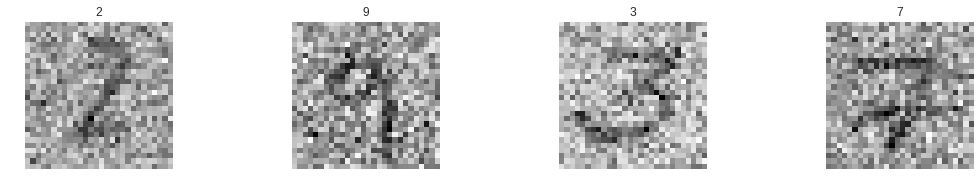

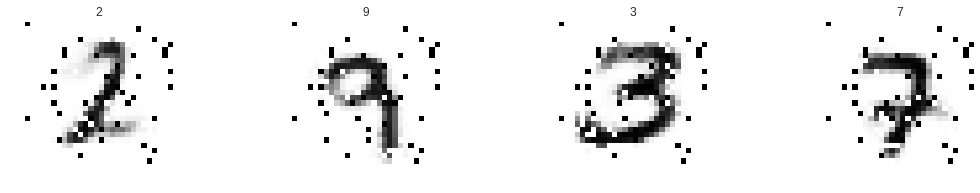

In [64]:
display_images(test_images_noisy.reshape(-1,pixel_size,pixel_size),test_labels)
display_images(y_test_pred2.reshape(-1,pixel_size,pixel_size),test_labels)

The model learned the images and generated almost correct images
even from a very noisy set. The quality of regeneration can be further improved with
proper hyperparameter tuning.

#Denoising autoencoder in Keras
As Keras takes care of feeding the training set by batch size, we create a noisy training set to
feed as input for our model:

In [0]:
x_train_noisy = add_noise(x_train)

In [0]:
tf.reset_default_graph()
keras.backend.clear_session()

In [0]:
import keras
from keras.layers import Dense
from keras.models import Sequential

# hyperparameters
learning_rate = 0.001
batch_size = 100
n_epochs = 100
n_batches = int(mnist.train.num_examples/batch_size)

# number of pixels in the MNIST image as number of inputs
n_inputs = 784
n_outputs = n_inputs

# number of hidden layers
n_layers = 2
# neurons in each hidden layer
n_neurons = [512,256]

# add decoder layers:
n_neurons.extend(list(reversed(n_neurons)))

n_layers = n_layers * 2

In [12]:
model = Sequential()

# add input to first layer
model.add(Dense(units=n_neurons[0], activation='relu', 
                input_shape=(n_inputs,)))

for i in range(1,n_layers):
    model.add(Dense(units=n_neurons[i], activation='relu'))
    
# add last layer to output layer
model.add(Dense(units=n_outputs, activation='linear'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 784)               402192    
Total params: 1,132,816
Trainable params: 1,132,816
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='mse',
              optimizer=keras.optimizers.Adam(lr=learning_rate))
model.fit(x=x_train_noisy, y=x_train,
                batch_size=batch_size,
                epochs=n_epochs,
                verbose=0)

y_test_pred1 = model.predict(test_images)
y_test_pred2 = model.predict(test_images_noisy)

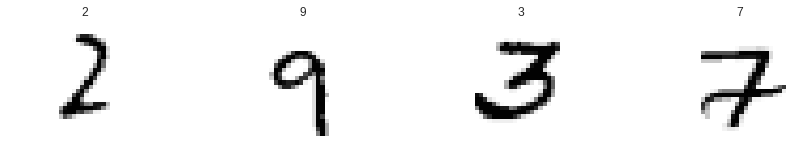

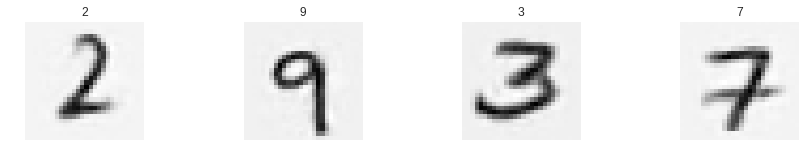

In [15]:
display_images(test_images.reshape(-1,pixel_size,pixel_size),test_labels)
display_images(y_test_pred1.reshape(-1,pixel_size,pixel_size),test_labels)

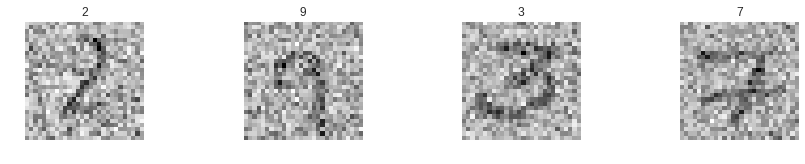

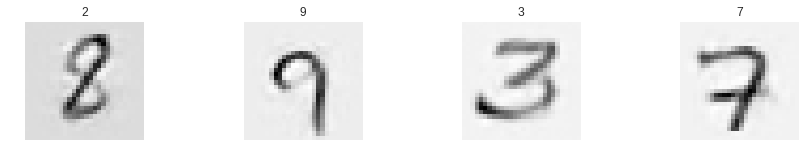

In [16]:
display_images(test_images_noisy.reshape(-1,pixel_size,pixel_size),test_labels)
display_images(y_test_pred2.reshape(-1,pixel_size,pixel_size),test_labels)

#Variational autoencoder in TensorFlow
Variational autoencoders are the modern generative version of autoencoders.

Use a different coding style in TensorFlow to build the variational autoencoder for the purpose of demonstrating different styles.

In [0]:
tf.reset_default_graph()
keras.backend.clear_session()

In [0]:
# hyperparameters
learning_rate = 0.001
n_epochs = 20
batch_size = 100
n_batches = int(mnist.train.num_examples/batch_size)

# number of pixels in the MNIST image as number of inputs
n_inputs = 784
n_outputs = n_inputs

define a parameter dictionary to hold the weight and bias parameters:

In [0]:
params = {}

Define the number of hidden layers in each of the encoder and decoder:

In [0]:
# number of hidden layers
n_layers = 2
# neurons in each hidden layers
n_neurons = [512, 256]

**The new addition in a variational encoder is that we define the dimensions of the
latent variable z**:

In [0]:
n_neurons_z = 128 # the dimensions of latent variables

use the activation tanh:

In [0]:
activation = tf.nn.tanh

In [0]:
# input images
x = tf.placeholder(dtype=tf.float32, name='x', shape=[None, n_inputs]) 
# output images
y = tf.placeholder(dtype=tf.float32, name='y', shape=[None, n_outputs]) 

define the input layer

In [0]:
# x is input layer
layer = x

Define the biases and weights for the encoder network and add layers. 

The
**encoder network** for *variational autoencoders* is also known as **recognition
network** or **inference network** or **probabilistic encoder network**:

In [0]:
# add recognition / inference / probablistic encoder network weights, biases and layers
for i in range(0, n_layers):
  name = 'w_e_{0:04d}'.format(i)
  params[name] = tf.get_variable(name=name,
                                 shape=[n_inputs if i==0 else n_neurons[i-1],
                                        n_neurons[i]],
                                 initializer=tf.glorot_uniform_initializer()
                                )
  
  name = 'b_e_{0:04d}'.format(i)
  params[name] = tf.Variable(tf.zeros([n_neurons[i]]),
                             name=name
                            )
  
  layer = activation(tf.matmul(layer,
                               params['w_e_{0:04d}'.format(i)],
                              )+ params['b_e_{0:04d}'.format(i)]
                    )

Next, add the layers for mean and variance of the latent variables:

In [0]:
name='w_e_z_mean'
params[name] = tf.get_variable(name=name,
                               shape=[n_neurons[n_layers-1], n_neurons_z],
                               initializer=tf.glorot_uniform_initializer()
                              )
name='b_e_z_mean'
params[name] = tf.Variable(tf.zeros([n_neurons_z]),
                           name=name
                          )
z_mean = tf.matmul(layer, params['w_e_z_mean']) + params['b_e_z_mean']

name='w_e_z_log_var'
params[name] = tf.get_variable(name=name,
                               shape=[n_neurons[n_layers-1], n_neurons_z],
                               initializer=tf.glorot_uniform_initializer()
                              )
name='b_e_z_log_var'
params[name] = tf.Variable(tf.zeros([n_neurons_z]),
                     name='b_e_z_log_var'
                    )

z_log_var = tf.matmul(layer, params['w_e_z_log_var']) + params['b_e_z_log_var']

Next, define the epsilon variable representing the noise distribution of the same
shape as the variable holding the variance of z:

In [0]:
# noise distribution
epsilon = tf.random_normal(tf.shape(z_log_var), 
                           mean=0, 
                           stddev=1.0,
                           dtype=tf.float32, 
                           name='epsilon'
                          )

Define a posterior distribution based on the mean, log variance, and noise:

In [0]:
# posterior distribution
z = z_mean + tf.exp(z_log_var * 0.5) * epsilon

Next, define the weights and biases for the decoder network and add the decoder
layers. 

The **decoder network** in *variational autoencoder* is also known as
**probabilistic decoder** or **generator network**.

In [0]:
# add generator / probablistic decoder network weights, biases and layers
layer = z

In [0]:
for i in range(n_layers-1,-1,-1):
    name='w_d_{0:04d}'.format(i)
    params[name] = tf.get_variable(name=name, 
                                   shape=[n_neurons_z if i==n_layers-1 else n_neurons[i+1],
                                          n_neurons[i]], 
                                   initializer=tf.glorot_uniform_initializer()
                                  )
    name='b_d_{0:04d}'.format(i)
    params[name] = tf.Variable(tf.zeros([n_neurons[i]]),
                         name=name 
                        )
    layer = activation(tf.matmul(layer, params['w_d_{0:04d}'.format(i)]) + 
                          params['b_d_{0:04d}'.format(i)])

Finally, define the output layer:

In [0]:
name='w_d_z_mean'
params[name] = tf.get_variable(name=name,
                               shape=[n_neurons[0],n_outputs],
                               initializer=tf.glorot_uniform_initializer()
                              )
name='b_d_z_mean'
params[name] = tf.Variable(tf.zeros([n_outputs]),
                     name=name
                    )
name='w_d_z_log_var'    
params[name] = tf.Variable(tf.random_normal([n_neurons[0],
                                             n_outputs]),
                           name=name
                          )
name='b_d_z_log_var'
params[name] = tf.Variable(tf.zeros([n_outputs]),
                           name=name
                          )

layer = tf.nn.sigmoid(tf.matmul(layer, params['w_d_z_mean']) + 
                          params['b_d_z_mean'])
                        
model = layer

In variation autoencoders, we have the *reconstruction loss* and the *regularization
loss*. Define the loss function as the sum of reconstruction loss and regularization
loss:

In [0]:
# loss function
rec_loss = -tf.reduce_sum(y 
                          * tf.log(1e-10 + model) 
                          + (1-y) 
                          * tf.log(1e-10 + 1 - model),
                          1
                         )
reg_loss = -0.5 * tf.reduce_sum(1 
                                + z_log_var 
                                - tf.square(z_mean) 
                                - tf.exp(z_log_var), 
                                1
                               )            
loss = tf.reduce_mean(rec_loss+reg_loss)
# optimizer function
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer = optimizer.minimize(loss)

Train the model and generate the images from non-noisy and noisy test
images:

In [76]:
with tf.Session() as tfs:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for batch in range(n_batches):
            x_batch, _ = mnist.train.next_batch(batch_size)
            x_batch_noisy = add_noise(x_batch)
            feed_dict={x: x_batch_noisy, y: x_batch}
            _,batch_loss = tfs.run([optimizer,loss], feed_dict=feed_dict)
            epoch_loss += batch_loss 
        if (epoch%10==9) or (epoch==0):
            average_loss = epoch_loss / n_batches
            print('epoch: {0:04d}   loss = {1:0.6f}'
                  .format(epoch,average_loss))

    # predict images using autoencoder model trained            
    y_test_pred1 = tfs.run(model, feed_dict={x: test_images})
    y_test_pred2 = tfs.run(model, feed_dict={x: test_images_noisy})

epoch: 0000   loss = 198.760503
epoch: 0009   loss = 125.145774
epoch: 0019   loss = 119.259175


Display the non-noisy test images:

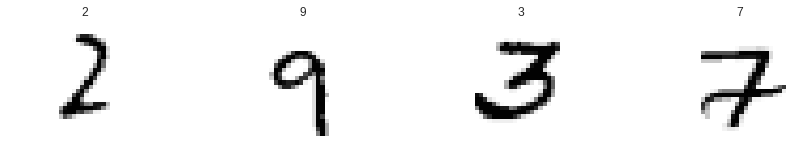

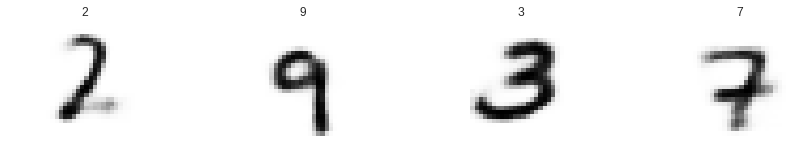

In [77]:
display_images(test_images.reshape(-1,pixel_size,pixel_size),test_labels)
display_images(y_test_pred1.reshape(-1,pixel_size,pixel_size),test_labels)

Display the noisy test images

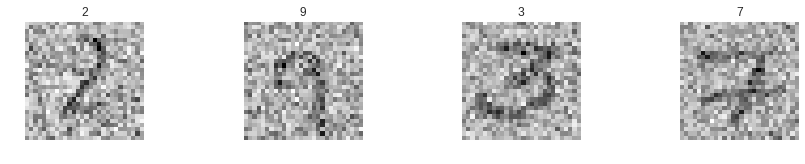

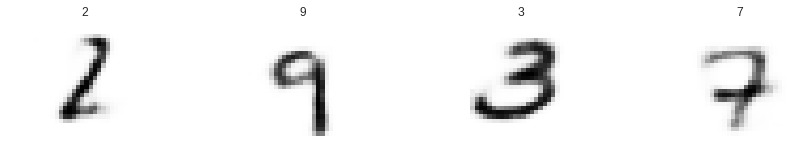

In [78]:
display_images(test_images_noisy.reshape(-1,pixel_size,pixel_size),test_labels)
display_images(y_test_pred2.reshape(-1,pixel_size,pixel_size),test_labels)

#Variational autoencoder in Keras
In Keras, building the variational autoencoder is much easier and with lesser lines of
code. The Keras variational autoencoders are best built using the functional style. So far we
have used the sequential style of building the models in Keras, and now in this example, we
will see the functional style of building the VAE model in Keras.

Define the hyper-parameters and the number of neurons in the hidden layers and
the latent variables layer:

In [0]:
tf.reset_default_graph()
keras.backend.clear_session()

In [0]:
import keras
from keras.layers import Lambda, Dense, Input, Layer
from keras.models import Model
from keras import backend as K
    
# hyperparameters
learning_rate = 0.001
batch_size = 100
n_batches = int(mnist.train.num_examples/batch_size)

# number of pixels in the MNIST image as number of inputs
n_inputs = 784
n_outputs = n_inputs

# number of hidden layers
n_layers = 2
# neurons in each hidden layer
n_neurons = [512,256]
# the dimensions of latent variables
n_neurons_z = 128 

Build the input layer:

In [0]:
x = Input(shape=(n_inputs,), name='input')

Build the encoder layers, along with mean and variance layers for the latent
variables:

In [0]:
layer = x

# build encoder
for i in range(n_layers):
    layer = Dense(units=n_neurons[i], activation='relu',name='enc_{0}'.format(i))(layer)

z_mean = Dense(units=n_neurons_z,name='z_mean')(layer)
z_log_var = Dense(units=n_neurons_z,name='z_log_v')(layer)

Create the noise and posterior distributions:

In [0]:
# noise distribution
epsilon = K.random_normal(shape=K.shape(z_log_var), 
                           mean=0, 
                           stddev=1.0
                         )

# posterior distribution
#z = Lambda(z_mean + K.exp(z_log_var * 0.5) * epsilon,
z = Lambda(lambda zargs: zargs[0] + K.exp(zargs[1] * 0.5) * epsilon,
           name='z'
          )([z_mean,z_log_var])

Add the decoder layers:

In [0]:
# add generator / probablistic decoder network layers
layer = z

for i in range(n_layers-1,-1,-1):
    layer = Dense(units=n_neurons[i], activation='relu',name='dec_{0}'.format(i))(layer)

Define the final output layer:

In [0]:
y_hat = Dense(units=n_outputs, activation='sigmoid',name='output')(layer)

Finally, define the model from the input layer and the output layer and display
the model summary:

In [54]:
model = Model(x,y_hat)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 784)          0                                            
__________________________________________________________________________________________________
enc_0 (Dense)                   (None, 512)          401920      input[0][0]                      
__________________________________________________________________________________________________
enc_1 (Dense)                   (None, 256)          131328      enc_0[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 128)          32896       enc_1[0][0]                      
__________________________________________________________________________________________________
z_log_v (D

Define a function that calculates the sum of reconstruction and regularization
loss:

In [0]:
def vae_loss(y, y_hat):
        rec_loss = -K.sum(y * K.log(1e-10 + y_hat) + (1-y) * K.log(1e-10 + 1 - y_hat), 
                          axis=-1)
        reg_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
         
        loss = K.mean(rec_loss+reg_loss)
        return loss

Train the model,

In [0]:
model.compile(loss=vae_loss,
              optimizer=keras.optimizers.Adam(lr=learning_rate)
             )
n_epochs=50

model.fit(x=x_train_noisy, y=x_train,
                batch_size=batch_size,
                epochs=n_epochs,
                verbose=0)

y_test_pred1 = model.predict(test_images)
y_test_pred2 = model.predict(test_images_noisy)

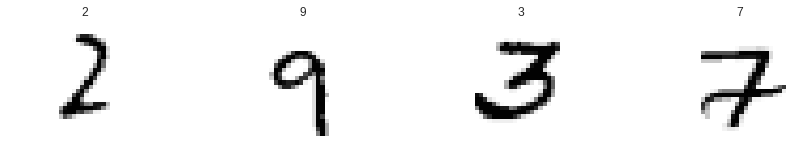

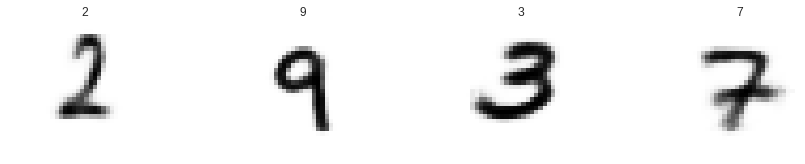

In [58]:
display_images(test_images.reshape(-1,pixel_size,pixel_size),test_labels)
display_images(y_test_pred1.reshape(-1,pixel_size,pixel_size),test_labels)

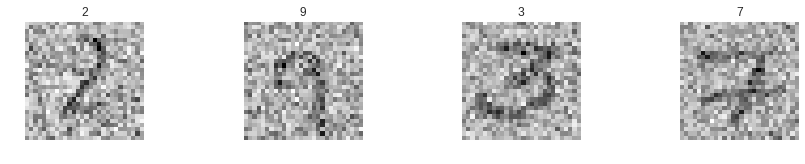

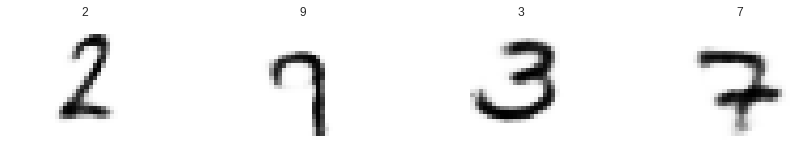

In [59]:
display_images(test_images_noisy.reshape(-1,pixel_size,pixel_size),test_labels)
display_images(y_test_pred2.reshape(-1,pixel_size,pixel_size),test_labels)